In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.vq import kmeans2
from typing import Sequence
from cv2.typing import MatLike

SiftDetectionResult = tuple[Sequence[cv.KeyPoint], MatLike]


def bf_match(
    des1: MatLike,
    des2: MatLike,
    kp1: Sequence[cv.KeyPoint],
    kp2: Sequence[cv.KeyPoint],
    matches_per_object: int = 20,
    n_objects: int = 3,
) -> Sequence[Sequence[cv.DMatch]]:
    """Optimized brute-force matching with ratio test using matrix operations."""
    # Compute pairwise distances
    distances = np.linalg.norm(des1[:, np.newaxis] - des2, axis=2)

    # Find two smallest distances
    sorted_indices = np.argsort(distances, axis=1)
    smallest_distances = distances[np.arange(len(des1)), sorted_indices[:, 0]]
    second_smallest_distances = distances[
        np.arange(len(des1)), sorted_indices[:, 1]
    ]

    # Apply ratio test
    mask = smallest_distances < 0.75 * second_smallest_distances

    # Create DMatch objects
    matches = [
        cv.DMatch(i, sorted_indices[i, 0], distances[i, sorted_indices[i, 0]])
        for i in np.where(mask)[0]
    ]

    # Extract the keypoints' (x, y) coordinates for the matched features
    matched_kp_coords = np.array([kp2[m.trainIdx].pt for m in matches])

    # Use kmeans2 from scipy to cluster keypoints into n_objects groups
    centroids, labels = kmeans2(matched_kp_coords, n_objects, minit='points')

    # Get the top 'matches_per_object' matches for each cluster
    final_matches = []
    for i in range(n_objects):
        cluster_indices = np.where(labels == i)[0]
        cluster_matches = [matches[idx] for idx in cluster_indices]
        
        # Sort matches in this cluster by distance
        cluster_matches = sorted(cluster_matches, key=lambda x: x.distance)
        
        # Add top matches from this cluster
        final_matches.extend(cluster_matches[:matches_per_object])

    # For drawMatchesKnn, the matches need to be in a specific format
    final_matches = [[m] for m in final_matches]

    return final_matches


def showImage(img: MatLike):
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

In [2]:
img1 = cv.imread('hw1-3-1.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('hw1-3-2.jpg', cv.IMREAD_GRAYSCALE)

In [3]:
sift: cv.SIFT = cv.SIFT_create()

res1: SiftDetectionResult = sift.detectAndCompute(img1, None)
res2: SiftDetectionResult = sift.detectAndCompute(img2, None)
kp1, des1 = res1
kp2, des2 = res2

In [4]:
distances = np.linalg.norm(des1[:, np.newaxis] - des2, axis=2)

In [5]:
sorted_indices = np.argsort(distances, axis=1)
smallest_distances = distances[np.arange(len(des1)), sorted_indices[:, 0]]
second_smallest_distances = distances[np.arange(len(des1)), sorted_indices[:, 1]]

In [10]:
# Apply ratio test
mask = smallest_distances < 0.75 * second_smallest_distances

# Create DMatch objects
matches = [
    cv.DMatch(i, sorted_indices[i, 0], distances[i, sorted_indices[i, 0]])
    for i in np.where(mask)[0]
]

# Extract the keypoints' (x, y) coordinates for the matched features
matched_kp_coords = np.array([kp2[m.trainIdx].pt for m in matches])

# Use kmeans2 from scipy to cluster keypoints into n_objects groups
centroids, labels = kmeans2(matched_kp_coords, 3, minit='points')

# Get the top 'matches_per_object' matches for each cluster
final_matches = []
for i in range(3):
    cluster_indices = np.where(labels == i)[0]
    cluster_matches = [matches[idx] for idx in cluster_indices]
    
    # Sort matches in this cluster by distance
    cluster_matches = sorted(cluster_matches, key=lambda x: x.distance)
    
    # Add top matches from this cluster
    final_matches.extend(cluster_matches[:20])

# For drawMatchesKnn, the matches need to be in a specific format
final_matches = [[m] for m in final_matches]

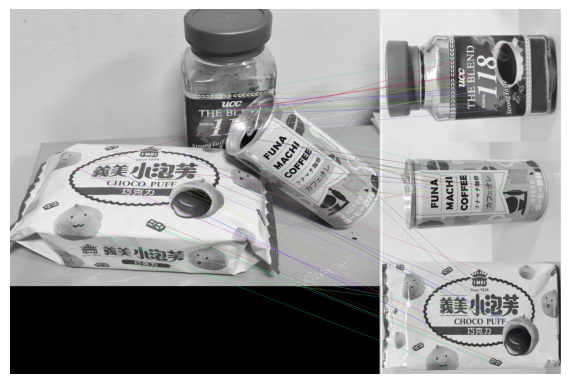

In [11]:
img3 = cv.drawMatchesKnn(
    img1,
    kp1,
    img2,
    kp2,
    final_matches,
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
showImage(img3)